---
format:
    html:
        embed-resources: true
---

### EDA for cervical cancer dataset


In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook_connected"
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import norm, skew

In [ ]:
# Import dataset
cesc_df_original = pd.read_csv("../../data/raw-data/cesc/cesc-clinical.tsv", sep="\t")

# Create a copy of the original dataframe to work on
cesc_df = cesc_df_original.copy()

# Display first few rows of the dataset
cesc_df.head()

,project.project_id,cases.case_id,cases.consent_type,cases.days_to_consent,cases.days_to_lost_to_followup,cases.disease_type,cases.index_date,cases.lost_to_followup,cases.primary_site,cases.submitter_id,...,treatments.treatment_duration,treatments.treatment_effect,treatments.treatment_effect_indicator,treatments.treatment_frequency,treatments.treatment_id,treatments.treatment_intent_type,treatments.treatment_or_therapy,treatments.treatment_outcome,treatments.treatment_outcome_duration,treatments.treatment_type
0,TCGA-CESC,00ad0ffe-2105-4829-a495-1c2aceb5bb31,Informed Consent,0,'--,Squamous Cell Neoplasms,Diagnosis,Yes,Cervix uteri,TCGA-EK-A2R9,...,'--,'--,'--,'--,672b3cf9-bb40-4f6f-a1c9-69ac3383fbd5,'--,'--,'--,'--,"Hysterectomy, NOS"
1,TCGA-CESC,00ad0ffe-2105-4829-a495-1c2aceb5bb31,Informed Consent,0,'--,Squamous Cell Neoplasms,Diagnosis,Yes,Cervix uteri,TCGA-EK-A2R9,...,'--,'--,'--,'--,d4baa31f-8c1f-5333-afcd-836816fd1a2a,Adjuvant,unknown,'--,'--,"Pharmaceutical Therapy, NOS"
2,TCGA-CESC,00ad0ffe-2105-4829-a495-1c2aceb5bb31,Informed Consent,0,'--,Squamous Cell Neoplasms,Diagnosis,Yes,Cervix uteri,TCGA-EK-A2R9,...,'--,'--,'--,'--,e79370ba-36f0-4639-bc8f-119ba2b2457b,Adjuvant,unknown,'--,'--,"Radiation Therapy, NOS"
3,TCGA-CESC,00bca18c-b3d4-45a3-8f19-034cc40449a4,Informed Consent,2108,'--,Squamous Cell Neoplasms,Diagnosis,Yes,Cervix uteri,TCGA-C5-A2LV,...,'--,'--,'--,'--,277d525e-9674-4954-b427-3e829d469b8f,'--,'--,'--,'--,"Hysterectomy, NOS"
4,TCGA-CESC,00bca18c-b3d4-45a3-8f19-034cc40449a4,Informed Consent,2108,'--,Squamous Cell Neoplasms,Diagnosis,Yes,Cervix uteri,TCGA-C5-A2LV,...,'--,'--,'--,'--,788ff156-d009-46f7-b832-f39b11ed13ac,Adjuvant,no,'--,'--,"Radiation Therapy, NOS"


From the first rows, we can see that there are several columns with missing values, represented as '-- . These values will be turned to NA for easier handling

In [3]:
# Replace "'--" as NA
cesc_df_original.replace('\'--', np.nan, inplace=True)
cesc_df.replace('\'--', np.nan, inplace=True)

# Inspect key columns for survival analysis

In [4]:
# List all cols starting with 'demographic'
demographic_cols = [col for col in cesc_df.columns if col.startswith('demographic')]
print("Columns starting with 'demographic':")
for col in demographic_cols:
    print(f"  - {col}")
print(f"\nTotal demographic columns: {len(demographic_cols)}")



Columns starting with 'demographic':
  - demographic.age_at_index
  - demographic.age_is_obfuscated
  - demographic.cause_of_death
  - demographic.cause_of_death_source
  - demographic.country_of_birth
  - demographic.country_of_residence_at_enrollment
  - demographic.days_to_birth
  - demographic.days_to_death
  - demographic.demographic_id
  - demographic.education_level
  - demographic.ethnicity
  - demographic.gender
  - demographic.marital_status
  - demographic.occupation_duration_years
  - demographic.population_group
  - demographic.premature_at_birth
  - demographic.race
  - demographic.submitter_id
  - demographic.vital_status
  - demographic.weeks_gestation_at_birth
  - demographic.year_of_birth
  - demographic.year_of_death

Total demographic columns: 22


In [5]:
# Check unique values in 'demographic.days_to_death'
cesc_df["demographic.days_to_death"].unique()

array([nan, '543', '144', '355', '2052', '2859', '348', '469', '1394',
       '4086', '253', '14', '506', '570', '951', '1245', '861', '2094',
       '305', '607', '1186', '636', '642', '275', '879', '284', '370',
       '523', '1118', '1453', '100', '227', '978', '132', '1011', '52',
       '442', '252', '2520', '955', '166', '1083', '1372', '555', '1065',
       '157', '414', '74', '908', '266', '471', '837', '3046', '1210',
       '104', '350', '2888', '633', '492', '494', '829', '477', '638',
       '582', '715', '1692', '773', '604', '2032', '659', '3097'],
      dtype=object)

In [6]:
# Check for percentage of missing values in 'demographic.days_to_death'
missing_percentage = cesc_df["demographic.days_to_death"].isnull().mean()
print(f"'Percentage of missing values in 'demographic.days_to_death' {missing_percentage:.2f}")

'Percentage of missing values in 'demographic.days_to_death' 0.72


In [7]:
# Check to see if status is 'alive' where days_to_death is missing
missing_death_status = cesc_df[cesc_df["demographic.days_to_death"].isnull()]["demographic.vital_status"].value_counts()
missing_death_status

demographic.vital_status
Alive    1103
Name: count, dtype: int64

We can assume that the demographic.days_to_death column is crucial for survival analysis, as it indicates the time until death for each patient. Despite a significant number of missing values in this column, these are for patients who are still alive, as indicated by the demographic.vital_status column. Therefore, we can retain this column for analysis, treating missing values as censored data.

In [8]:
# Drop rows where days_to_death is missing and vital_status is 'Dead'
cesc_df = cesc_df[~((cesc_df["demographic.days_to_death"].isnull()) & (cesc_df["demographic.vital_status"] == 'Dead'))]

In [9]:
# Check for percentage of missing values in diagnoses.days_to_last_follow_up
missing_percentage = cesc_df["diagnoses.days_to_last_follow_up"].isnull().mean()
print(f"'Percentage of missing values in 'diagnoses.days_to_last_follow_up' {missing_percentage:.2f}")

'Percentage of missing values in 'diagnoses.days_to_last_follow_up' 0.12


In [10]:
# Check the distribution of vital_status when days_to_last_follow_up is missing
missing_followup_status = cesc_df[cesc_df["diagnoses.days_to_last_follow_up"].isnull()]["demographic.vital_status"].value_counts()
missing_followup_status

demographic.vital_status
Dead     105
Alive     86
Name: count, dtype: int64

In [11]:
# Check the percentage of missing values for the following columns:
# - demographic.year_of_birth
# - demographic.year_of_death
# - demographic.vital_status
# - demographic.cause_of_death
# - demographic.education_level
cols_to_check = [
    'demographic.year_of_birth',
    'demographic.age_at_index',
    'demographic.cause_of_death',
    'demographic.year_of_death',
    'demographic.vital_status',
    'demographic.cause_of_death',
    'demographic.education_level'
]
for col in cols_to_check:
    missing_percentage = cesc_df[col].isnull().mean() * 100
    print(f"{col}: {missing_percentage:.2f}% missing values")

demographic.year_of_birth: 100.00% missing values
demographic.age_at_index: 0.00% missing values
demographic.cause_of_death: 71.86% missing values
demographic.year_of_death: 100.00% missing values
demographic.vital_status: 0.00% missing values
demographic.cause_of_death: 71.86% missing values
demographic.education_level: 100.00% missing values


A lot of missing values in key demographic columns, especially in cause of death become a limiting factor for analysis.

In [12]:
# Distribution of demographic.vital_status
vital_status_counts = cesc_df['demographic.vital_status'].value_counts(dropna=False)
print("\ndemographic.vital_status distribution:")
print(vital_status_counts)


demographic.vital_status distribution:
demographic.vital_status
Alive    1103
Dead      432
Name: count, dtype: int64


However, the demographic.vital_status column has fewer missing values, which may still allow for some analysis regarding survival status. Despite large number of missing values in demographic.days_to_death, we can assume it is because the patient is alive since the missing values correspond to alive in the vital_status column. In addition, days_to_last_follow_up in the diagnoses table also has fewer missing values, which may be useful for survival time analysis.

# Check for missing values

<Figure size 1500x800 with 0 Axes>

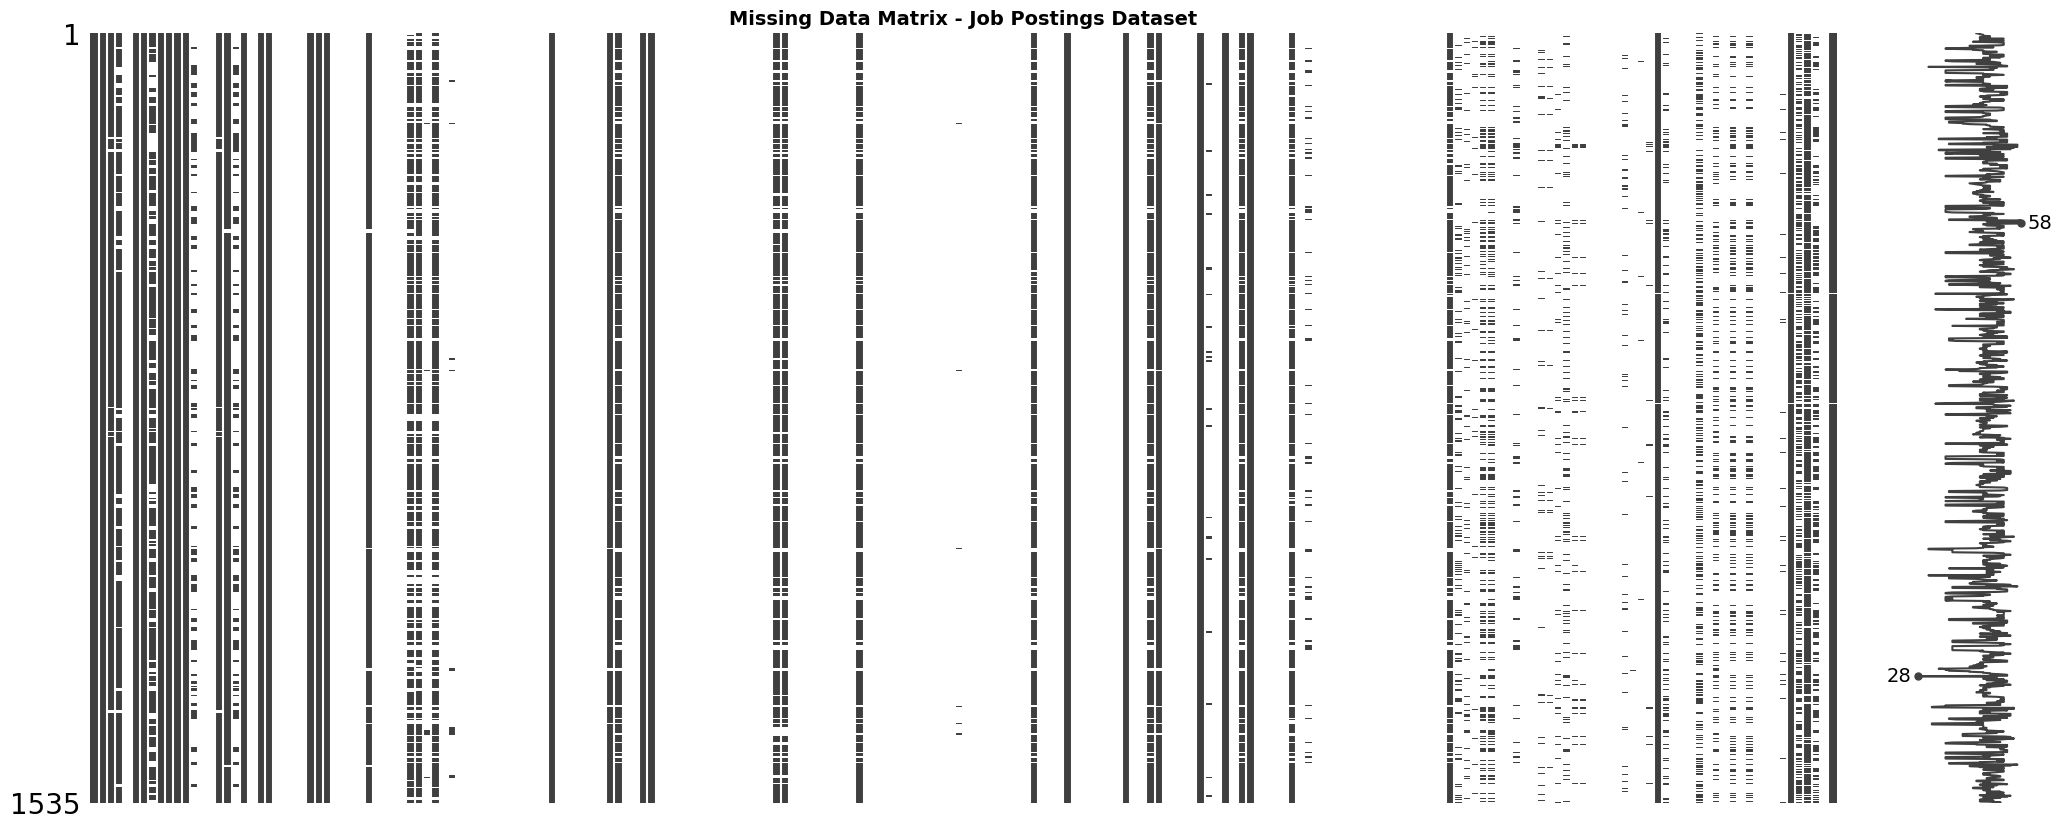

In [ ]:
# Missing data visualization
plt.figure(figsize=(15, 8))
msno.matrix(cesc_df)
plt.title("Missing Data Matrix - cervical cancer Dataset", fontsize=14, fontweight='bold')
plt.show()

In [14]:
# Drop columns with more than 30% missing values except for demographic.days_to_death and diagnoses.days_to_last_follow_up

# Calculate missing percentage for each column
missing_percentages = cesc_df.isnull().mean()

# Identify columns to drop (more than 30% missing, excluding the exceptions)
exceptions = ['demographic.days_to_death', 'diagnoses.days_to_last_follow_up']
columns_to_drop = []

for col in cesc_df.columns:
    if col not in exceptions and missing_percentages[col] > 0.3:
        columns_to_drop.append(col)

print(f"Columns to be dropped due to >30% missing values: {columns_to_drop}")

# Drop the identified columns
cesc_df = cesc_df.drop(columns=columns_to_drop)

# Display the shape of the cleaned dataset
cesc_df.shape

Columns to be dropped due to >30% missing values: ['cases.days_to_lost_to_followup', 'demographic.cause_of_death', 'demographic.cause_of_death_source', 'demographic.country_of_birth', 'demographic.education_level', 'demographic.marital_status', 'demographic.occupation_duration_years', 'demographic.population_group', 'demographic.premature_at_birth', 'demographic.weeks_gestation_at_birth', 'demographic.year_of_birth', 'demographic.year_of_death', 'diagnoses.adrenal_hormone', 'diagnoses.ajcc_clinical_m', 'diagnoses.ajcc_clinical_n', 'diagnoses.ajcc_clinical_stage', 'diagnoses.ajcc_clinical_t', 'diagnoses.ajcc_pathologic_stage', 'diagnoses.ajcc_serum_tumor_markers', 'diagnoses.ajcc_staging_system_edition', 'diagnoses.ann_arbor_b_symptoms', 'diagnoses.ann_arbor_b_symptoms_described', 'diagnoses.ann_arbor_clinical_stage', 'diagnoses.ann_arbor_extranodal_involvement', 'diagnoses.ann_arbor_pathologic_stage', 'diagnoses.best_overall_response', 'diagnoses.burkitt_lymphoma_clinical_variant', 'di

(1535, 47)

<Figure size 1500x800 with 0 Axes>

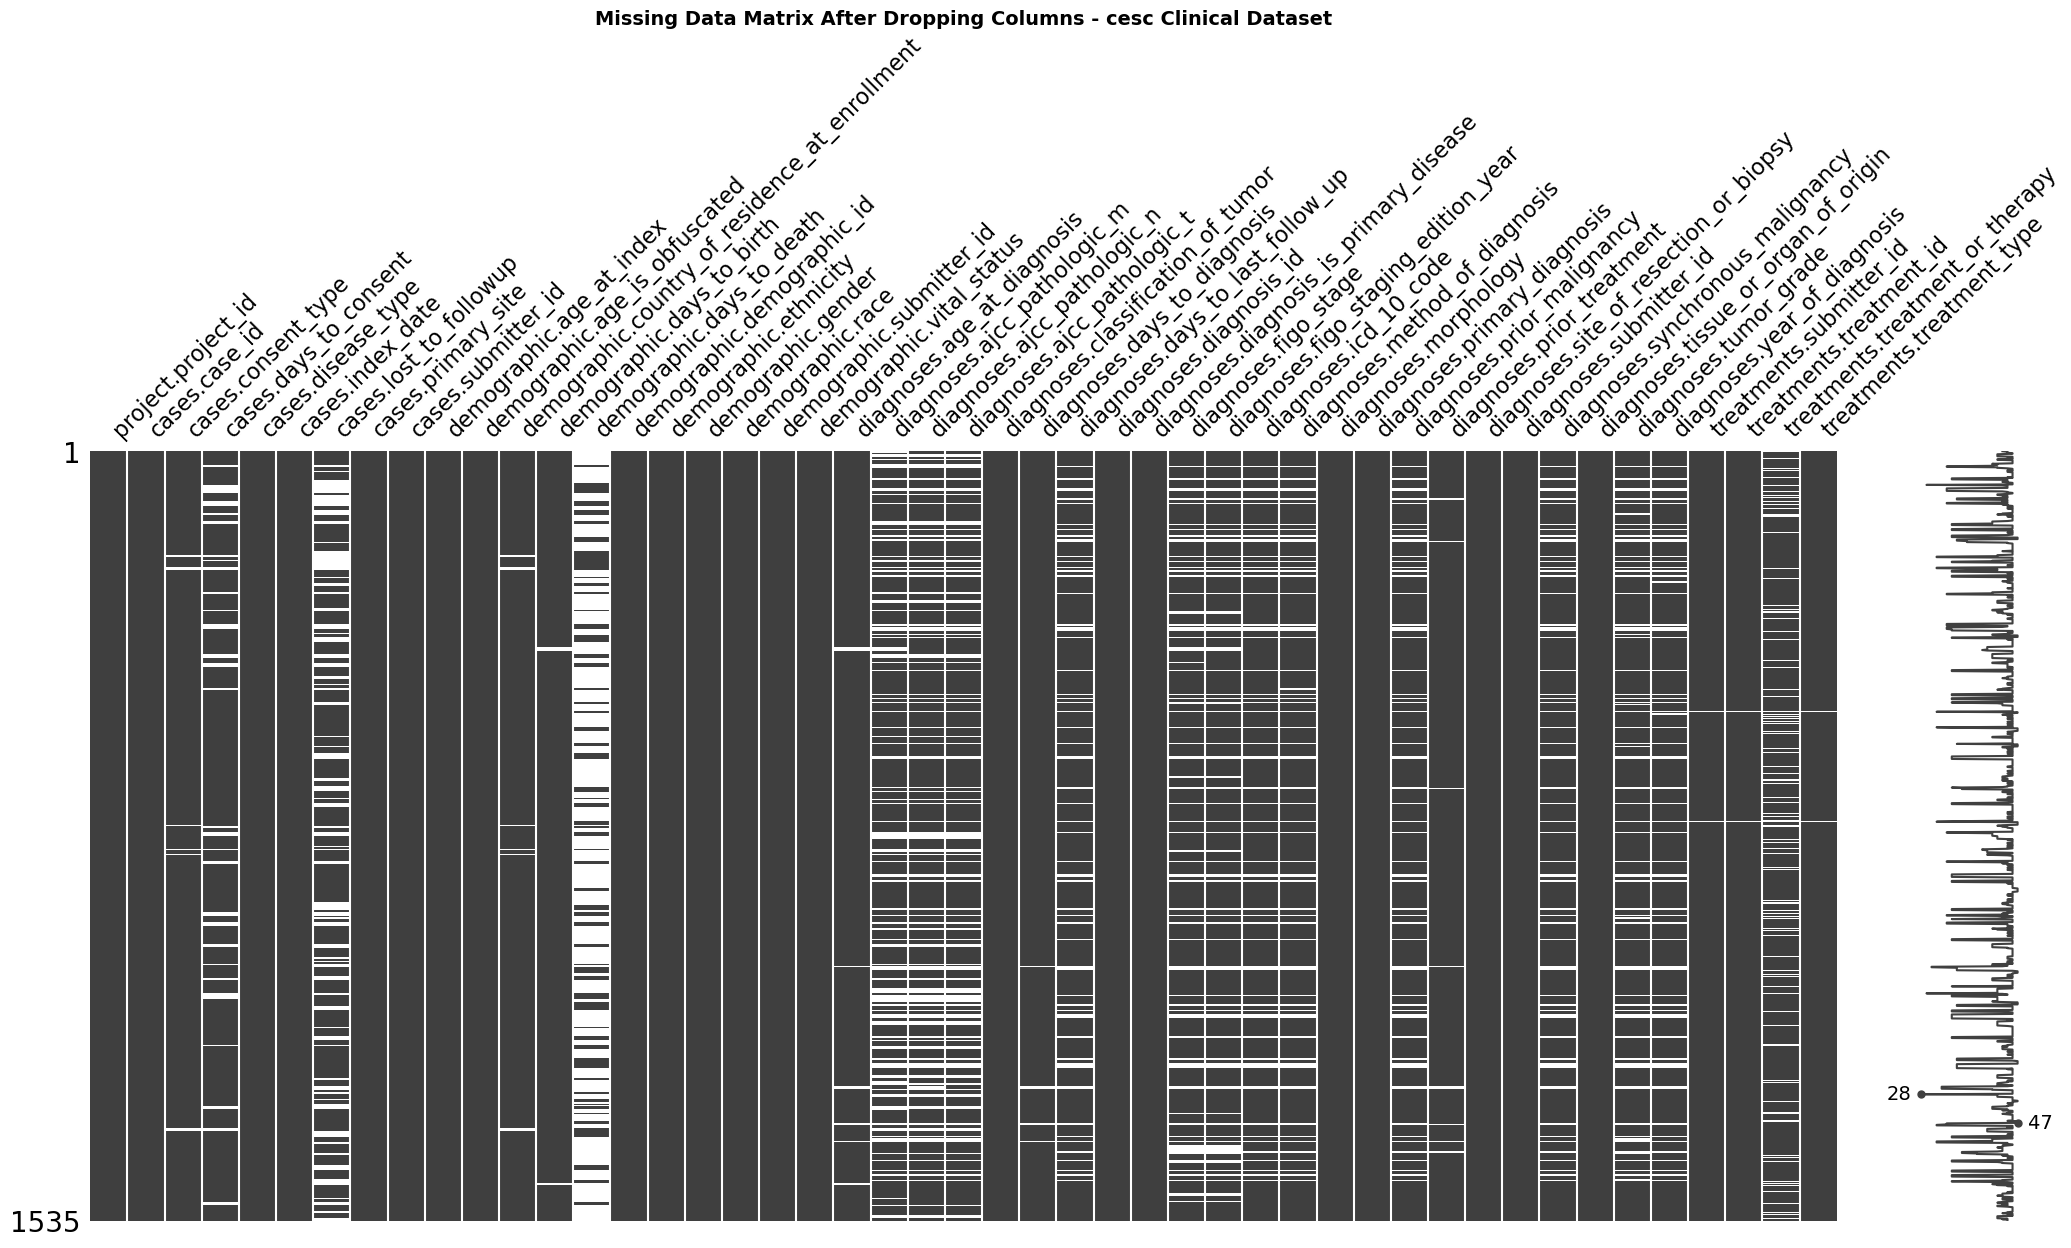

In [15]:
# Check distribution na values after dropping columns
plt.figure(figsize=(15, 8))
msno.matrix(cesc_df)
plt.title("Missing Data Matrix After Dropping Columns - cesc Clinical Dataset", fontsize=14, fontweight='bold')
plt.show()

# Check for duplicate IDs

In [16]:
# Count unique IDs (cases.submitter_id)

unique_ids = cesc_df['cases.submitter_id'].nunique()
print(f"Number of unique IDs: {unique_ids}")

Number of unique IDs: 307


The TGCA cesc dataset contains 1,082 unique patient IDs (cases.submitter_id) but 3554 rows in total. This is because the TCGA Schema is designed to have multiple samples per patient, capturing different aspects of the tumor biology. Each patient may have multiple entries corresponding to different sample types, such as primary tumor, metastatic tumor, or normal tissue adjacent to the tumor. This allows for a more comprehensive analysis of the cancer's characteristics and progression within the same individual.

The tcga schema is hierarchical as follows:

Case (cesc) -> Diagnosis -> Follow-up -> Treatment -> Biospecimens

Most cesc patients have:
- 1 diagnosis
- 1 - 5 follow-up entries
- 1 - 3 treatments
- 2 - 4 tissue samples (tumor and normal)

# Filter columns based on task

Columns that are not relevant to the predictive modeling task will be dropped. These include identifiers, dates, and other metadata that do not contribute to the prediction of breast cancer outcomes such as the following:

- cases.consent_type
- cases.days_to_consent
- demographic.days_to_birth
- demographic.age_at_index (will preserve diagnosis.age_at_diagnosis instead for age at diagnosis)
- diagnoses.ajcc_staging_system_edition
- diagnoses.diagnosis_id (captured in disease_type)
- diagnoses.icd_10_code (captured in disease_type)
- diagnoses.year_of_diagnosis (interested in age at diagnosis instead)
- treatments.treatment_id

In [17]:
# Drop irrelevant columns
columns_to_drop = [
    'cases.consent_type',
    'cases.days_to_consent',
    'demographic.days_to_birth',
    'demographic.age_at_index',
    'demographic.demographic_id',
    'diagnoses.diagnosis_id',
    'diagnoses.icd_10_code',
    'diagnoses.year_of_diagnosis',
    'treatments.treatment_id',
    'demographic.country_of_residence_at_enrollment',
    'diagnoses.diagnosis_is_primary_disease',
    'demographic.age_is_obfuscated'
]

# Drop the existing columns
cesc_df = cesc_df.drop(columns=columns_to_drop)

print(f"Dataset shape after dropping columns: {cesc_df.shape}")

Dataset shape after dropping columns: (1535, 35)


In [18]:
# Check remaining column names
cesc_df.columns.tolist()

['project.project_id',
 'cases.case_id',
 'cases.disease_type',
 'cases.index_date',
 'cases.lost_to_followup',
 'cases.primary_site',
 'cases.submitter_id',
 'demographic.days_to_death',
 'demographic.ethnicity',
 'demographic.gender',
 'demographic.race',
 'demographic.submitter_id',
 'demographic.vital_status',
 'diagnoses.age_at_diagnosis',
 'diagnoses.ajcc_pathologic_m',
 'diagnoses.ajcc_pathologic_n',
 'diagnoses.ajcc_pathologic_t',
 'diagnoses.classification_of_tumor',
 'diagnoses.days_to_diagnosis',
 'diagnoses.days_to_last_follow_up',
 'diagnoses.figo_stage',
 'diagnoses.figo_staging_edition_year',
 'diagnoses.method_of_diagnosis',
 'diagnoses.morphology',
 'diagnoses.primary_diagnosis',
 'diagnoses.prior_malignancy',
 'diagnoses.prior_treatment',
 'diagnoses.site_of_resection_or_biopsy',
 'diagnoses.submitter_id',
 'diagnoses.synchronous_malignancy',
 'diagnoses.tissue_or_organ_of_origin',
 'diagnoses.tumor_grade',
 'treatments.submitter_id',
 'treatments.treatment_or_therapy

<Figure size 1500x800 with 0 Axes>

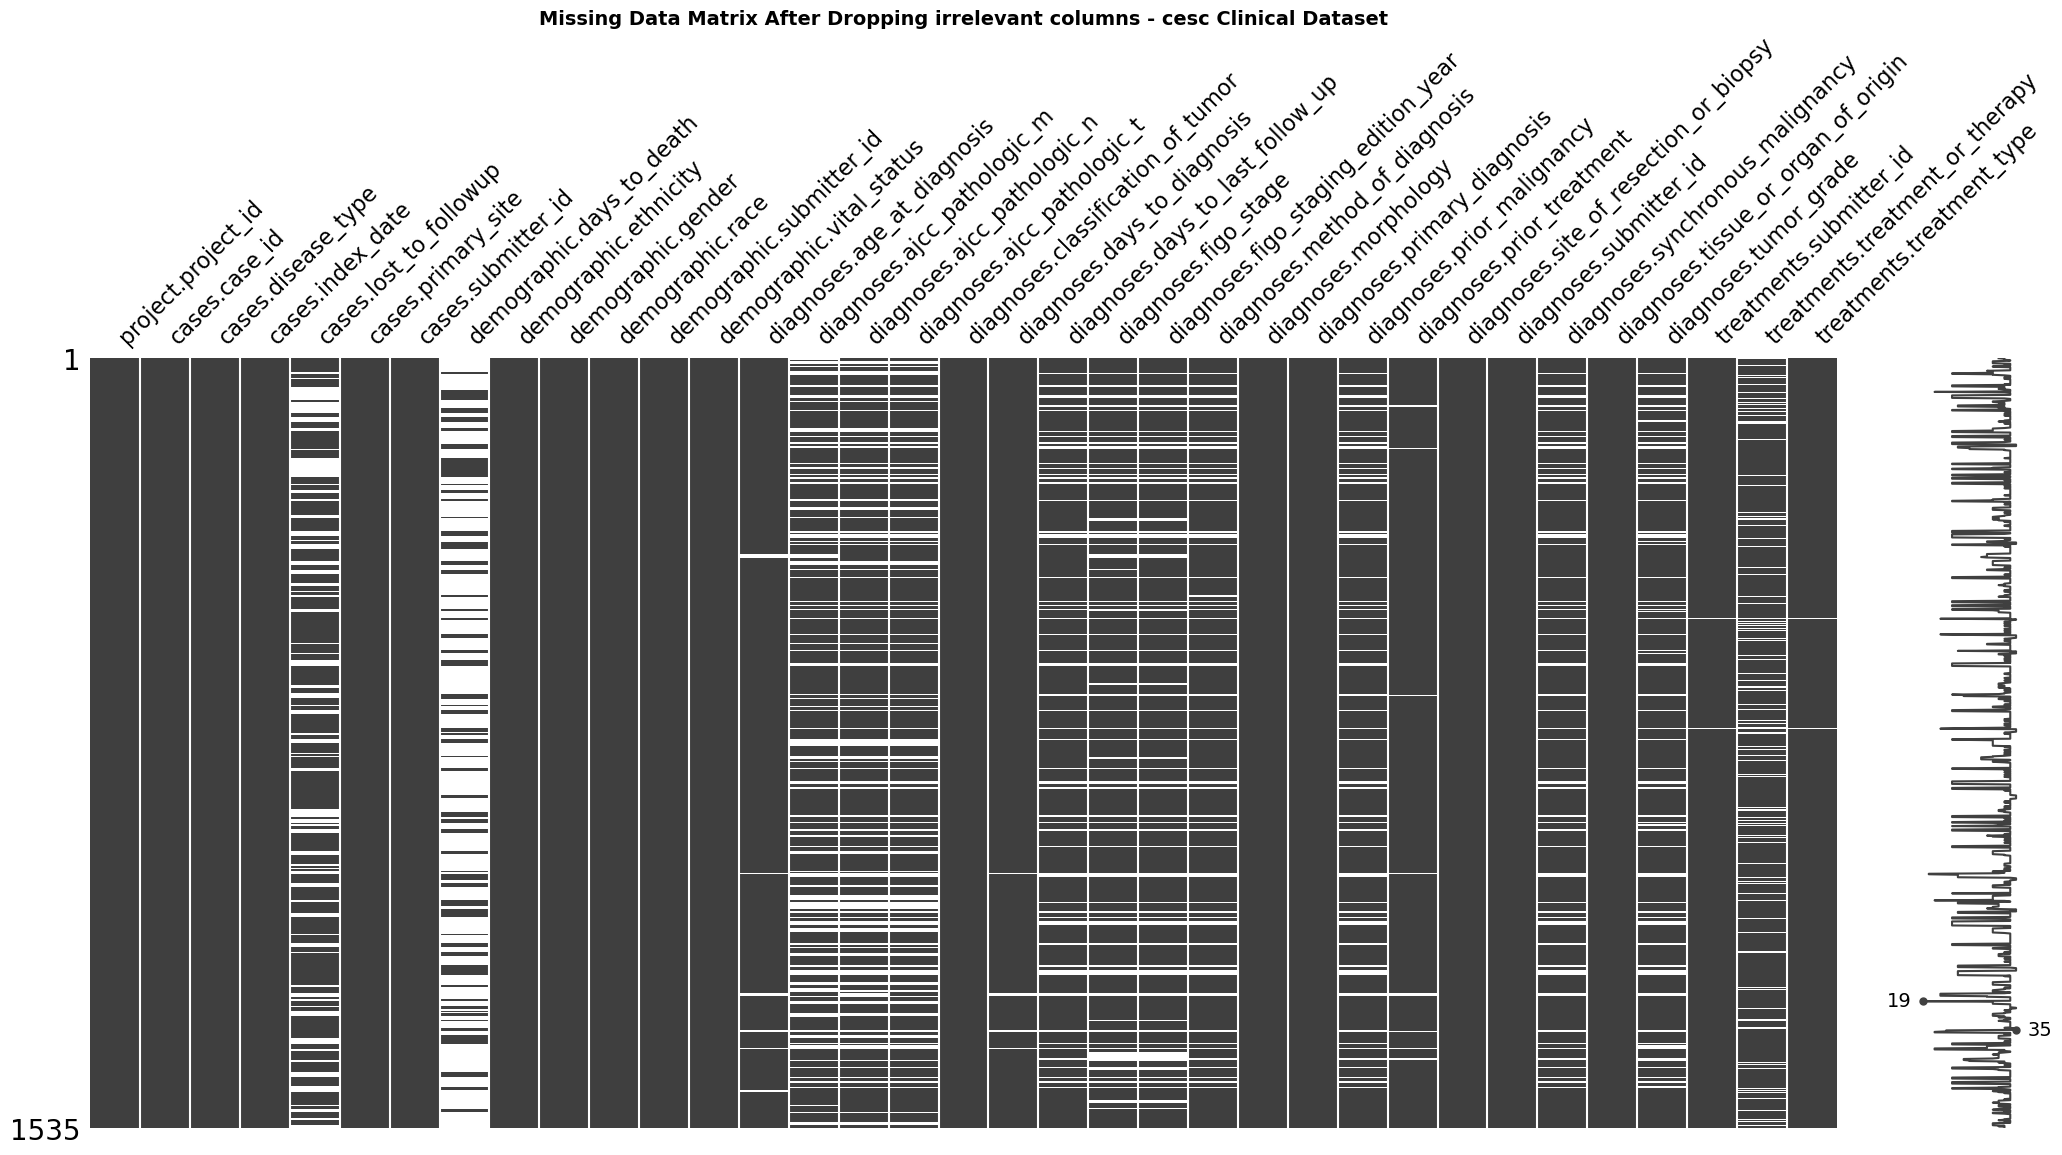

In [19]:
# Using msno to visualize missing data in remaining columns
plt.figure(figsize=(15, 8))
msno.matrix(cesc_df)
plt.title("Missing Data Matrix After Dropping irrelevant columns - cesc Clinical Dataset", fontsize=14, fontweight='bold')
plt.show()

In [20]:
# Check missing value percentages again

for col in cesc_df.columns:
    missing_percentage = cesc_df[col].isnull().mean() * 100
    print(f"{col}: {missing_percentage:.2f}% missing values")

project.project_id: 0.00% missing values
cases.case_id: 0.00% missing values
cases.disease_type: 0.00% missing values
cases.index_date: 0.00% missing values
cases.lost_to_followup: 27.23% missing values
cases.primary_site: 0.00% missing values
cases.submitter_id: 0.00% missing values
demographic.days_to_death: 71.86% missing values
demographic.ethnicity: 0.00% missing values
demographic.gender: 0.00% missing values
demographic.race: 0.00% missing values
demographic.submitter_id: 0.00% missing values
demographic.vital_status: 0.00% missing values
diagnoses.age_at_diagnosis: 1.76% missing values
diagnoses.ajcc_pathologic_m: 23.52% missing values
diagnoses.ajcc_pathologic_n: 22.61% missing values
diagnoses.ajcc_pathologic_t: 22.28% missing values
diagnoses.classification_of_tumor: 0.00% missing values
diagnoses.days_to_diagnosis: 1.04% missing values
diagnoses.days_to_last_follow_up: 12.44% missing values
diagnoses.figo_stage: 16.22% missing values
diagnoses.figo_staging_edition_year: 16.

In [21]:
# Drop rows with missing cases.lost_to_followup
cesc_df = cesc_df.dropna(subset=['cases.lost_to_followup'])
cesc_df.shape

(1117, 35)

In [22]:
# Check distribution of rows that have a lot of missing values
cesc_df["na_count"] = cesc_df.isna().sum(axis=1)
na_count_distribution = cesc_df['na_count'].value_counts().sort_index()
print("\nDistribution of rows by number of missing values:")
print(na_count_distribution)


Distribution of rows by number of missing values:
na_count
0      52
1     675
2     115
3      51
4      83
5      19
6       6
8       3
9       3
10     31
11     67
12      3
13      3
14      5
16      1
Name: count, dtype: int64


In [23]:
# Delete rows that have 10 or more missing values (representing over 25% of that entity info missing)
cesc_df = cesc_df[cesc_df['na_count'] < 9].drop(columns=['na_count'])

In [24]:
# Delete rows that have missing age_at_diagnosis info since this is a critical variable for our analysis
cesc_df = cesc_df[cesc_df['diagnoses.age_at_diagnosis'].notna()]

In [25]:
# Check missing value percentages again

for col in cesc_df.columns:
    missing_percentage = cesc_df[col].isnull().mean() * 100
    print(f"{col}: {missing_percentage:.2f}% missing values")

project.project_id: 0.00% missing values
cases.case_id: 0.00% missing values
cases.disease_type: 0.00% missing values
cases.index_date: 0.00% missing values
cases.lost_to_followup: 0.00% missing values
cases.primary_site: 0.00% missing values
cases.submitter_id: 0.00% missing values
demographic.days_to_death: 91.57% missing values
demographic.ethnicity: 0.00% missing values
demographic.gender: 0.00% missing values
demographic.race: 0.00% missing values
demographic.submitter_id: 0.00% missing values
demographic.vital_status: 0.00% missing values
diagnoses.age_at_diagnosis: 0.00% missing values
diagnoses.ajcc_pathologic_m: 12.15% missing values
diagnoses.ajcc_pathologic_n: 11.24% missing values
diagnoses.ajcc_pathologic_t: 11.24% missing values
diagnoses.classification_of_tumor: 0.00% missing values
diagnoses.days_to_diagnosis: 0.00% missing values
diagnoses.days_to_last_follow_up: 0.30% missing values
diagnoses.figo_stage: 4.82% missing values
diagnoses.figo_staging_edition_year: 4.62% 

In [26]:
# Check the distribution of the method_of_diagnosis since it has a significantly higher missing value percentage
method_of_diagnosis_counts = cesc_df['diagnoses.method_of_diagnosis'].value_counts(dropna=False)
print("\ndiagnoses.method_of_diagnosis distribution:")
print(method_of_diagnosis_counts)


diagnoses.method_of_diagnosis distribution:
diagnoses.method_of_diagnosis
Biopsy                              852
Surgical Resection                   61
Cytology                             54
Dilation and Curettage Procedure     26
NaN                                   3
Name: count, dtype: int64


Due to the heavy imbalance leaning towards Biopsy for the diagnoses.method_of_diagnosis column, we can replace missing values with 'Biopsy' to retain more rows for analysis.

In [27]:
# Set pandas options to display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [28]:
# Check distribution of diagnoses.ajcc_pathologic_n 
ajcc_pathologic_stage_counts = cesc_df['diagnoses.ajcc_pathologic_n'].value_counts(dropna=False)
print("\ndiagnoses.ajcc_pathologic_n distribution:")
print(ajcc_pathologic_stage_counts)


diagnoses.ajcc_pathologic_n distribution:
diagnoses.ajcc_pathologic_n
N0     452
NX     265
N1     167
NaN    112
Name: count, dtype: int64


In [29]:
# Check distribution of diagnoses.ajcc_pathologic_m 
ajcc_pathologic_stage_counts = cesc_df['diagnoses.ajcc_pathologic_m'].value_counts(dropna=False)
print("\ndiagnoses.ajcc_pathologic_m distribution:")
print(ajcc_pathologic_stage_counts)


diagnoses.ajcc_pathologic_m distribution:
diagnoses.ajcc_pathologic_m
MX     472
M0     358
NaN    121
M1      45
Name: count, dtype: int64


In [30]:
# Check distribution of diagnoses.ajcc_pathologic_t 
ajcc_pathologic_stage_counts = cesc_df['diagnoses.ajcc_pathologic_t'].value_counts(dropna=False)
print("\ndiagnoses.ajcc_pathologic_t distribution:")
print(ajcc_pathologic_stage_counts)


diagnoses.ajcc_pathologic_t distribution:
diagnoses.ajcc_pathologic_t
T1b1    246
T2b     132
T1b2    115
NaN     112
T1b      94
TX       50
T2a2     49
T3b      39
T2a      35
T2a1     32
T4       30
T2       23
T3a      13
T3       12
Tis       6
T1a1      5
T1        3
Name: count, dtype: int64


The missing values in the diagnoses.ajcc_pathologic_t, diagnoses.ajcc_pathologic_n, and diagnoses.ajcc_pathologic_m columns will be replaced by the mode of each column respectively due to the high imbalance.

In [31]:
# Check distribution of diagnoses.treatment_or_therapy
treatment_or_therapy_counts = cesc_df['treatments.treatment_or_therapy'].value_counts(dropna=False)
print("\ntreatments.treatment_or_therapy distribution:")
print(treatment_or_therapy_counts)


treatments.treatment_or_therapy distribution:
treatments.treatment_or_therapy
yes        545
no         224
NaN        128
unknown     99
Name: count, dtype: int64


In [32]:
# Check distribution od diagnoses.figo_stage
figo_stage_counts = cesc_df['diagnoses.figo_stage'].value_counts(dropna=False)
print("\ndiagnoses.figo_stage distribution:")
print(figo_stage_counts)


diagnoses.figo_stage distribution:
diagnoses.figo_stage
Stage IB1     272
Stage IIB     161
Stage IB2     134
Stage IIIB    117
Stage IB       72
NaN            48
Stage IIA      34
Stage IVB      33
Stage IIA2     31
Stage IIA1     21
Stage IIIA     19
Stage I        16
Stage II       14
Stage IVA      10
Stage III       6
Stage IA1       5
Stage IA2       3
Name: count, dtype: int64


In [33]:
# Check the distribution of diagnoses.figo_staging_edition_year
figo_staging_edition_year_counts = cesc_df['diagnoses.figo_staging_edition_year'].value_counts(dropna=False)
print("\ndiagnoses.figo_staging_edition_year distribution:")
print(figo_staging_edition_year_counts)


diagnoses.figo_staging_edition_year distribution:
diagnoses.figo_staging_edition_year
2009    753
1995    134
1988     63
NaN      46
Name: count, dtype: int64


In [34]:
# Check the distribution of prior_malignancy
prior_malignancy_counts = cesc_df['diagnoses.prior_malignancy'].value_counts(dropna=False)
print("\ndiagnoses.prior_malignancy distribution:")
print(prior_malignancy_counts)


diagnoses.prior_malignancy distribution:
diagnoses.prior_malignancy
no              962
yes              20
not reported     11
NaN               3
Name: count, dtype: int64


In [35]:
# Check distribution of diagnoses.tumor_grade
tumor_grade_counts = cesc_df['diagnoses.tumor_grade'].value_counts(dropna=False)
print("\ndiagnoses.tumor_grade distribution:")
print(tumor_grade_counts)


diagnoses.tumor_grade distribution:
diagnoses.tumor_grade
G2     437
G3     399
GX      86
G1      60
NaN     10
G4       4
Name: count, dtype: int64


# Clean NA values 

Replace the missing values in the following columns based on the assigned strategy:
- diagnoses.method_of_diagnosis: 'Core Biopsy' (most frequent)
- diagnoses.diagnosis_is_primary_disease: 'True' (most frequent)
- diagnoses.prior_malignancy: 'False' (most frequent)
- diagnoses.prior_treatment: 'False' (most frequent)
- diagnoses.sites_of_involvement: 'Breast' (most frequent)
- diagnoses.synchronous_malignancy: 'False' (most frequent)
- diagnoses.treatment_or_therapy: True (most frequent)
- diagnoses.figo_stage: 'Stage IB1' (most frequent)
- diagnoses.figo_staging_edition_year: '2009' (most frequent)

Dropping rows with missing diagnoses.ajcc_pathologic_m, diagnoses.ajcc_pathologic_n, diagnoses.ajcc_pathologic_t and tumor_grade since they are a small percentage and there is no clear imbalance to guide imputation.

In [36]:
# Drop rows with missing diagnoses.ajcc_pathologic_m, diagnoses.ajcc_pathologic_n, diagnoses.ajcc_pathologic_t and tumor_grade
cesc_df = cesc_df.dropna(subset=['diagnoses.ajcc_pathologic_m', 'diagnoses.ajcc_pathologic_n', 'diagnoses.ajcc_pathologic_t', 'diagnoses.tumor_grade'])

In [37]:
# Replace missing values based on the strategy above:

# Replace with most frequent values
cesc_df['diagnoses.method_of_diagnosis'] = cesc_df['diagnoses.method_of_diagnosis'].fillna('Biopsy')
cesc_df['diagnoses.prior_malignancy'] = cesc_df['diagnoses.prior_malignancy'].fillna('no')
cesc_df['diagnoses.prior_treatment'] = cesc_df['diagnoses.prior_treatment'].fillna('no')
cesc_df['diagnoses.synchronous_malignancy'] = cesc_df['diagnoses.synchronous_malignancy'].fillna('no')
cesc_df['treatments.treatment_or_therapy'] = cesc_df['treatments.treatment_or_therapy'].fillna('yes')
cesc_df['diagnoses.figo_stage'] = cesc_df['diagnoses.figo_stage'].fillna('Stage IB1')
cesc_df['diagnoses.figo_staging_edition_year'] = cesc_df['diagnoses.figo_staging_edition_year'].fillna(2009)


In [38]:
# Check distribution of treatments.treatment_or_therapy after imputation
treatment_or_therapy_counts = cesc_df['treatments.treatment_or_therapy'].value_counts(dropna=False)
print("\ntreatments.treatment_or_therapy distribution after imputation:")
print(treatment_or_therapy_counts)


treatments.treatment_or_therapy distribution after imputation:
treatments.treatment_or_therapy
yes        583
no         216
unknown     73
Name: count, dtype: int64


In [39]:
# Percentage of missing values in each column

missing_percentages = cesc_df.isnull().mean() * 100
print("\nPercentage of missing values in each column:")
print(missing_percentages)


Percentage of missing values in each column:
project.project_id                        0.000000
cases.case_id                             0.000000
cases.disease_type                        0.000000
cases.index_date                          0.000000
cases.lost_to_followup                    0.000000
cases.primary_site                        0.000000
cases.submitter_id                        0.000000
demographic.days_to_death                92.889908
demographic.ethnicity                     0.000000
demographic.gender                        0.000000
demographic.race                          0.000000
demographic.submitter_id                  0.000000
demographic.vital_status                  0.000000
diagnoses.age_at_diagnosis                0.000000
diagnoses.ajcc_pathologic_m               0.000000
diagnoses.ajcc_pathologic_n               0.000000
diagnoses.ajcc_pathologic_t               0.000000
diagnoses.classification_of_tumor         0.000000
diagnoses.days_to_diagnosis         

# Check for consistent data types

In [40]:
# Check column data types

cesc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 872 entries, 3 to 1523
Data columns (total 35 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   project.project_id                     872 non-null    object
 1   cases.case_id                          872 non-null    object
 2   cases.disease_type                     872 non-null    object
 3   cases.index_date                       872 non-null    object
 4   cases.lost_to_followup                 872 non-null    object
 5   cases.primary_site                     872 non-null    object
 6   cases.submitter_id                     872 non-null    object
 7   demographic.days_to_death              62 non-null     object
 8   demographic.ethnicity                  872 non-null    object
 9   demographic.gender                     872 non-null    object
 10  demographic.race                       872 non-null    object
 11  demographic.submitter_i

In [41]:
# Check the statistical summary of diagnoses.age_at_diagnosis

# Convert to numeric 
cesc_df['diagnoses.age_at_diagnosis'] = pd.to_numeric(cesc_df['diagnoses.age_at_diagnosis'], errors='coerce')

# Statistical summary
print("Statistical Summary of Age at Diagnosis:")
print(cesc_df['diagnoses.age_at_diagnosis'].describe())

print(f"\nMean: {cesc_df['diagnoses.age_at_diagnosis'].mean():.2f}")
print(f"Median: {cesc_df['diagnoses.age_at_diagnosis'].median():.2f}")
print(f"Standard Deviation: {cesc_df['diagnoses.age_at_diagnosis'].std():.2f}")
print(f"Missing values: {cesc_df['diagnoses.age_at_diagnosis'].isna().sum()}")

Statistical Summary of Age at Diagnosis:
count      872.000000
mean     17612.810780
std       4448.299744
min       9186.000000
25%      14162.000000
50%      16894.000000
75%      20286.000000
max      29526.000000
Name: diagnoses.age_at_diagnosis, dtype: float64

Mean: 17612.81
Median: 16894.00
Standard Deviation: 4448.30
Missing values: 0


The age at diagnosis column has been converted to numeric but the values are in days. For analysis we will convert these to years by dividing by 365.25 (accounting for leap years) and rounding down

In [42]:
# Convert age at diagnosis from days to years (integer)
cesc_df['diagnoses.age_at_diagnosis'] = (cesc_df['diagnoses.age_at_diagnosis'] / 365.25).apply(np.floor)

In [43]:
# Convert to integer
cesc_df['diagnoses.age_at_diagnosis'] = pd.to_numeric(
    cesc_df['diagnoses.age_at_diagnosis'], 
    errors='coerce'
)
cesc_df['diagnoses.age_at_diagnosis'].dtype

dtype('float64')

In [44]:
# Change all object type columns to lowercase
for col in cesc_df.select_dtypes(include=['object']).columns:
    cesc_df[col] = cesc_df[col].astype(str).str.lower().replace('nan', np.nan)

In [45]:
# Strip whitespace from string columns
for col in cesc_df.select_dtypes(include=['object']).columns:
    cesc_df[col] = cesc_df[col].str.strip()

Change other columns to boolean as appropriate:
- diagnoses.diagnosis_is_primary_disease (from true/false strings)
- diagnoses.prior_malignancy (from no/yes strings)
- diagnoses.prior_treatment (from No/Yes strings)
- diagnoses.synchronous_malignancy (from no/yes strings)

In [46]:
# Convert diagnosis-related columns to boolean

# Convert diagnoses.prior_malignancy (yes/no to boolean)
cesc_df['diagnoses.prior_malignancy'] = cesc_df['diagnoses.prior_malignancy'].map({'yes': True, 'no': False})

# Convert diagnoses.prior_treatment (yes/no to boolean)
cesc_df['diagnoses.prior_treatment'] = cesc_df['diagnoses.prior_treatment'].map({'yes': True, 'no': False})

# Convert diagnoses.synchronous_malignancy (yes/no to boolean)
cesc_df['diagnoses.synchronous_malignancy'] = cesc_df['diagnoses.synchronous_malignancy'].map({'yes': True, 'no': False})

# Check the conversions
print("Conversion results:")
print(f"diagnoses.prior_malignancy dtype: {cesc_df['diagnoses.prior_malignancy'].dtype}")
print(f"diagnoses.prior_treatment dtype: {cesc_df['diagnoses.prior_treatment'].dtype}")
print(f"diagnoses.synchronous_malignancy dtype: {cesc_df['diagnoses.synchronous_malignancy'].dtype}")

print("\nValue counts for each column:")
for col in ['diagnoses.prior_malignancy', 
           'diagnoses.prior_treatment', 'diagnoses.synchronous_malignancy']:
    print(f"\n{col}:")
    print(cesc_df[col].value_counts())

Conversion results:
diagnoses.prior_malignancy dtype: object
diagnoses.prior_treatment dtype: bool
diagnoses.synchronous_malignancy dtype: object

Value counts for each column:

diagnoses.prior_malignancy:
diagnoses.prior_malignancy
False    854
True      15
Name: count, dtype: int64

diagnoses.prior_treatment:
diagnoses.prior_treatment
False    872
Name: count, dtype: int64

diagnoses.synchronous_malignancy:
diagnoses.synchronous_malignancy
False    869
Name: count, dtype: int64


# Data Engineering

In [47]:
# Percentage of missing values in each column
missing_percentages = cesc_df.isnull().mean() * 100
print("\nPercentage of missing values in each column:")
print(missing_percentages)


Percentage of missing values in each column:
project.project_id                        0.000000
cases.case_id                             0.000000
cases.disease_type                        0.000000
cases.index_date                          0.000000
cases.lost_to_followup                    0.000000
cases.primary_site                        0.000000
cases.submitter_id                        0.000000
demographic.days_to_death                92.889908
demographic.ethnicity                     0.000000
demographic.gender                        0.000000
demographic.race                          0.000000
demographic.submitter_id                  0.000000
demographic.vital_status                  0.000000
diagnoses.age_at_diagnosis                0.000000
diagnoses.ajcc_pathologic_m               0.000000
diagnoses.ajcc_pathologic_n               0.000000
diagnoses.ajcc_pathologic_t               0.000000
diagnoses.classification_of_tumor         0.000000
diagnoses.days_to_diagnosis         

In [48]:
# Check percentage of missing values in days_to_death when vital_status is 'dead'
missing_death_percentage = cesc_df[cesc_df['demographic.vital_status'] == 'dead']['demographic.days_to_death'].isnull().mean()
print(f"Percentage of missing values in 'demographic.days_to_death' when vital_status is 'dead': {missing_death_percentage:.2%}")    

Percentage of missing values in 'demographic.days_to_death' when vital_status is 'dead': 0.00%


In [49]:
# Percentage of missing values in days_to_last_follow_up when vital_status is 'alive'
missing_followup_percentage = cesc_df[cesc_df['demographic.vital_status'] == 'alive']['diagnoses.days_to_last_follow_up'].isnull().mean()
print(f"Percentage of missing values in 'diagnoses.days_to_last_follow_up' when vital_status is 'alive': {missing_followup_percentage:.2%}")

Percentage of missing values in 'diagnoses.days_to_last_follow_up' when vital_status is 'alive': 0.00%


In [50]:
# Create survival time column based on vital status
def calculate_survival_time(row):
    if row['demographic.vital_status'] == 'dead':
        return row['demographic.days_to_death']
    elif row['demographic.vital_status'] == 'alive':
        return row['diagnoses.days_to_last_follow_up']
    else:
        return np.nan
    
cesc_df['survival_time_days'] = cesc_df.apply(calculate_survival_time, axis=1)

In [51]:
# Check percentage of missing values in survival_time_days
missing_percentage = cesc_df['survival_time_days'].isnull().mean() * 100
print(f"Percentage of missing values in 'survival_time_days': {missing_percentage:.2f}%")

Percentage of missing values in 'survival_time_days': 0.00%


In [52]:
# Drop rows with missing survival_time_days
cesc_df = cesc_df[cesc_df['survival_time_days'].notna()]
cesc_df.shape

(872, 36)

In [53]:
# Drop duplicate rows before feature engineering
cesc_df = cesc_df.drop_duplicates()
cesc_df.shape

(872, 36)

In [54]:
# Extract diagnoses.behavior from diagnoses.morphology column (e.g., 8500/3 -> 3 where 3 is the behavior code)

# Mappings for behavior codes
behavior_mapping = {
    '0': 'benign',
    '2': 'in situ',
    '3': 'malignant'
}
# Extract behavior code and map to descriptive labels
cesc_df['diagnoses.behavior'] = cesc_df['diagnoses.morphology'].str.split('/').str[1].map(behavior_mapping)
# Check the new column
print("Value counts for diagnoses.behavior:")
print(cesc_df['diagnoses.behavior'].value_counts())

Value counts for diagnoses.behavior:
diagnoses.behavior
malignant    872
Name: count, dtype: int64


Note: There is a heavy class imbalance for diagnoses.behavior as over 95% of the entries are malignant.

In [55]:
cesc_df.head()

,project.project_id,cases.case_id,cases.disease_type,cases.index_date,cases.lost_to_followup,cases.primary_site,cases.submitter_id,demographic.days_to_death,demographic.ethnicity,demographic.gender,demographic.race,demographic.submitter_id,demographic.vital_status,diagnoses.age_at_diagnosis,diagnoses.ajcc_pathologic_m,diagnoses.ajcc_pathologic_n,diagnoses.ajcc_pathologic_t,diagnoses.classification_of_tumor,diagnoses.days_to_diagnosis,diagnoses.days_to_last_follow_up,diagnoses.figo_stage,diagnoses.figo_staging_edition_year,diagnoses.method_of_diagnosis,diagnoses.morphology,diagnoses.primary_diagnosis,diagnoses.prior_malignancy,diagnoses.prior_treatment,diagnoses.site_of_resection_or_biopsy,diagnoses.submitter_id,diagnoses.synchronous_malignancy,diagnoses.tissue_or_organ_of_origin,diagnoses.tumor_grade,treatments.submitter_id,treatments.treatment_or_therapy,treatments.treatment_type,survival_time_days,diagnoses.behavior
3,tcga-cesc,00bca18c-b3d4-45a3-8f19-034cc40449a4,squamous cell neoplasms,diagnosis,yes,cervix uteri,tcga-c5-a2lv,NaN,not hispanic or latino,female,black or african american,tcga-c5-a2lv_demographic,alive,36.0,mx,n1,t1b,primary,0,2234.0,stage ib,1995,biopsy,8070/3,"squamous cell carcinoma, nos",False,False,cervix uteri,tcga-c5-a2lv_diagnosis,False,cervix uteri,g3,tcga-c5-a2lv_treatment3,yes,"hysterectomy, nos",2234.0,malignant
4,tcga-cesc,00bca18c-b3d4-45a3-8f19-034cc40449a4,squamous cell neoplasms,diagnosis,yes,cervix uteri,tcga-c5-a2lv,NaN,not hispanic or latino,female,black or african american,tcga-c5-a2lv_demographic,alive,36.0,mx,n1,t1b,primary,0,2234.0,stage ib,1995,biopsy,8070/3,"squamous cell carcinoma, nos",False,False,cervix uteri,tcga-c5-a2lv_diagnosis,False,cervix uteri,g3,tcga-c5-a2lv_treatment2,no,"radiation therapy, nos",2234.0,malignant
5,tcga-cesc,00bca18c-b3d4-45a3-8f19-034cc40449a4,squamous cell neoplasms,diagnosis,yes,cervix uteri,tcga-c5-a2lv,NaN,not hispanic or latino,female,black or african american,tcga-c5-a2lv_demographic,alive,36.0,mx,n1,t1b,primary,0,2234.0,stage ib,1995,biopsy,8070/3,"squamous cell carcinoma, nos",False,False,cervix uteri,tcga-c5-a2lv_diagnosis,False,cervix uteri,g3,tcga-c5-a2lv_treatment,no,"pharmaceutical therapy, nos",2234.0,malignant
11,tcga-cesc,03804f9b-df7c-462c-8984-8eb3a5ed4999,squamous cell neoplasms,diagnosis,no,cervix uteri,tcga-vs-a9v2,NaN,not reported,female,white,tcga-vs-a9v2_demographic,alive,29.0,mx,n0,t1b,primary,0,555.0,stage ib1,2009,biopsy,8070/3,"squamous cell carcinoma, nos",False,False,cervix uteri,tcga-vs-a9v2_diagnosis,False,cervix uteri,g2,tcga-vs-a9v2_treatment3,yes,"radiation, 3d conformal",555.0,malignant
12,tcga-cesc,03804f9b-df7c-462c-8984-8eb3a5ed4999,squamous cell neoplasms,diagnosis,no,cervix uteri,tcga-vs-a9v2,NaN,not reported,female,white,tcga-vs-a9v2_demographic,alive,29.0,mx,n0,t1b,primary,0,555.0,stage ib1,2009,biopsy,8070/3,"squamous cell carcinoma, nos",False,False,cervix uteri,tcga-vs-a9v2_diagnosis,False,cervix uteri,g2,tcga-vs-a9v2_treatment2,no,"pharmaceutical therapy, nos",555.0,malignant


In [56]:
# Check distribution of missing values in columns after cleaning and data engineering
missing_percentages = cesc_df.isnull().mean() * 100
print("\nPercentage of missing values in each column:")
print(missing_percentages)


Percentage of missing values in each column:
project.project_id                        0.000000
cases.case_id                             0.000000
cases.disease_type                        0.000000
cases.index_date                          0.000000
cases.lost_to_followup                    0.000000
cases.primary_site                        0.000000
cases.submitter_id                        0.000000
demographic.days_to_death                92.889908
demographic.ethnicity                     0.000000
demographic.gender                        0.000000
demographic.race                          0.000000
demographic.submitter_id                  0.000000
demographic.vital_status                  0.000000
diagnoses.age_at_diagnosis                0.000000
diagnoses.ajcc_pathologic_m               0.000000
diagnoses.ajcc_pathologic_n               0.000000
diagnoses.ajcc_pathologic_t               0.000000
diagnoses.classification_of_tumor         0.000000
diagnoses.days_to_diagnosis         

In [57]:
# Replace missing prior_malignancy and synchronous_malignancy with False
cesc_df['diagnoses.prior_malignancy'] = cesc_df['diagnoses.prior_malignancy'].fillna(False)
cesc_df['diagnoses.synchronous_malignancy'] = cesc_df['diagnoses.synchronous_malignancy'].fillna(False)


In [58]:
cesc_df.head(1)

,project.project_id,cases.case_id,cases.disease_type,cases.index_date,cases.lost_to_followup,cases.primary_site,cases.submitter_id,demographic.days_to_death,demographic.ethnicity,demographic.gender,demographic.race,demographic.submitter_id,demographic.vital_status,diagnoses.age_at_diagnosis,diagnoses.ajcc_pathologic_m,diagnoses.ajcc_pathologic_n,diagnoses.ajcc_pathologic_t,diagnoses.classification_of_tumor,diagnoses.days_to_diagnosis,diagnoses.days_to_last_follow_up,diagnoses.figo_stage,diagnoses.figo_staging_edition_year,diagnoses.method_of_diagnosis,diagnoses.morphology,diagnoses.primary_diagnosis,diagnoses.prior_malignancy,diagnoses.prior_treatment,diagnoses.site_of_resection_or_biopsy,diagnoses.submitter_id,diagnoses.synchronous_malignancy,diagnoses.tissue_or_organ_of_origin,diagnoses.tumor_grade,treatments.submitter_id,treatments.treatment_or_therapy,treatments.treatment_type,survival_time_days,diagnoses.behavior
3,tcga-cesc,00bca18c-b3d4-45a3-8f19-034cc40449a4,squamous cell neoplasms,diagnosis,yes,cervix uteri,tcga-c5-a2lv,NaN,not hispanic or latino,female,black or african american,tcga-c5-a2lv_demographic,alive,36.0,mx,n1,t1b,primary,0,2234.0,stage ib,1995,biopsy,8070/3,"squamous cell carcinoma, nos",False,False,cervix uteri,tcga-c5-a2lv_diagnosis,False,cervix uteri,g3,tcga-c5-a2lv_treatment3,yes,"hysterectomy, nos",2234.0,malignant


# Cervical cancer exposure data cleaning

In [ ]:
# Open cesc exposure tsv data

cesc_exposure_df = pd.read_csv('../../data/raw-data/cesc/exposure.tsv', sep='\t')
cesc_exposure_df.head(3)

,project.project_id,cases.case_id,cases.submitter_id,exposures.age_at_last_exposure,exposures.age_at_onset,exposures.alcohol_days_per_week,exposures.alcohol_drinks_per_day,exposures.alcohol_frequency,exposures.alcohol_history,exposures.alcohol_intensity,exposures.alcohol_type,exposures.asbestos_exposure,exposures.asbestos_exposure_type,exposures.chemical_exposure_type,exposures.cigarettes_per_day,exposures.coal_dust_exposure,exposures.environmental_tobacco_smoke_exposure,exposures.exposure_duration,exposures.exposure_duration_hrs_per_day,exposures.exposure_duration_years,exposures.exposure_id,exposures.exposure_source,exposures.exposure_type,exposures.occupation_duration_years,exposures.occupation_type,exposures.pack_years_smoked,exposures.parent_with_radiation_exposure,exposures.radon_exposure,exposures.respirable_crystalline_silica_exposure,exposures.secondhand_smoke_as_child,exposures.smoking_frequency,exposures.submitter_id,exposures.time_between_waking_and_first_smoke,exposures.tobacco_smoking_onset_year,exposures.tobacco_smoking_quit_year,exposures.tobacco_smoking_status,exposures.type_of_smoke_exposure,exposures.type_of_tobacco_used,exposures.use_per_day,exposures.years_smoked
0,TCGA-CESC,00ad0ffe-2105-4829-a495-1c2aceb5bb31,TCGA-EK-A2R9,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,Tobacco,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,Not Reported,'--,'--,'--,'--
1,TCGA-CESC,00bca18c-b3d4-45a3-8f19-034cc40449a4,TCGA-C5-A2LV,'--,20,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,Tobacco,'--,'--,16.0,'--,'--,'--,'--,'--,'--,'--,'--,'--,Current Smoker,'--,'--,'--,'--
2,TCGA-CESC,010a807f-9dc0-4e14-9533-dcf478f3d947,TCGA-C5-A902,'--,14,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,Tobacco,'--,'--,21.0,'--,'--,'--,'--,'--,'--,'--,'--,'--,Current Smoker,'--,'--,'--,'--


In [60]:
# Change every column to lowercase
for col in cesc_exposure_df.select_dtypes(include=['object']).columns:
    cesc_exposure_df[col] = cesc_exposure_df[col].astype(str).str.lower().replace('nan', np.nan)

In [61]:
# Strip whitespace from string columns
for col in cesc_exposure_df.select_dtypes(include=['object']).columns:
    cesc_exposure_df[col] = cesc_exposure_df[col].str.strip()

In [62]:
# Double check for common cases.submitter_id between clinical and exposure datasets
common_ids = set(cesc_df['cases.submitter_id']).intersection(set(cesc_exposure_df['cases.submitter_id']))
print(f"Number of common cases.submitter_id between clinical and exposure datasets: {len(common_ids)}")

Number of common cases.submitter_id between clinical and exposure datasets: 184


In [63]:
# Replace "'--" as NA
cesc_exposure_df.replace('\'--', np.nan, inplace=True)
cesc_exposure_df.replace('\'--', np.nan, inplace=True)

In [64]:
# Check distribution of null values in exposure dataset
missing_percentages = cesc_exposure_df.isnull().mean() * 100
print("\nPercentage of missing values in each column of exposure dataset:")
print(missing_percentages)


Percentage of missing values in each column of exposure dataset:
project.project_id                                    0.000000
cases.case_id                                         0.000000
cases.submitter_id                                    0.000000
exposures.age_at_last_exposure                      100.000000
exposures.age_at_onset                               72.312704
exposures.alcohol_days_per_week                     100.000000
exposures.alcohol_drinks_per_day                    100.000000
exposures.alcohol_frequency                         100.000000
exposures.alcohol_history                           100.000000
exposures.alcohol_intensity                         100.000000
exposures.alcohol_type                              100.000000
exposures.asbestos_exposure                         100.000000
exposures.asbestos_exposure_type                    100.000000
exposures.chemical_exposure_type                    100.000000
exposures.cigarettes_per_day                        

In [65]:
# Check exposures.tobacco_smoking_status column since they are the only ones with low missing values
smoking_status_counts = cesc_exposure_df['exposures.tobacco_smoking_status'].value_counts(dropna=False)
print("\nexposures.tobacco_smoking_status distribution:")
print(smoking_status_counts)


exposures.tobacco_smoking_status distribution:
exposures.tobacco_smoking_status
lifelong non-smoker                                146
current smoker                                      64
current reformed smoker for < or = 15 yrs           40
not reported                                        32
unknown                                             12
current reformed smoker for > 15 yrs                 9
current reformed smoker, duration not specified      4
Name: count, dtype: int64


In [66]:
# Join clinical and exposure datasets on cases.submitter_id preserving only exposures.tobacco_smoking_status from exposure dataset
cesc_merged_df = pd.merge(
    cesc_df,
    cesc_exposure_df[['cases.submitter_id', 'exposures.tobacco_smoking_status']],
    on='cases.submitter_id',
    how='left'
)

In [67]:
cesc_exposure_df["exposures.tobacco_smoking_status"].head(5)

0                                 not reported
1                               current smoker
2                               current smoker
3                          lifelong non-smoker
4    current reformed smoker for < or = 15 yrs
Name: exposures.tobacco_smoking_status, dtype: object

In [68]:
cesc_merged_df.head(1)

,project.project_id,cases.case_id,cases.disease_type,cases.index_date,cases.lost_to_followup,cases.primary_site,cases.submitter_id,demographic.days_to_death,demographic.ethnicity,demographic.gender,demographic.race,demographic.submitter_id,demographic.vital_status,diagnoses.age_at_diagnosis,diagnoses.ajcc_pathologic_m,diagnoses.ajcc_pathologic_n,diagnoses.ajcc_pathologic_t,diagnoses.classification_of_tumor,diagnoses.days_to_diagnosis,diagnoses.days_to_last_follow_up,diagnoses.figo_stage,diagnoses.figo_staging_edition_year,diagnoses.method_of_diagnosis,diagnoses.morphology,diagnoses.primary_diagnosis,diagnoses.prior_malignancy,diagnoses.prior_treatment,diagnoses.site_of_resection_or_biopsy,diagnoses.submitter_id,diagnoses.synchronous_malignancy,diagnoses.tissue_or_organ_of_origin,diagnoses.tumor_grade,treatments.submitter_id,treatments.treatment_or_therapy,treatments.treatment_type,survival_time_days,diagnoses.behavior,exposures.tobacco_smoking_status
0,tcga-cesc,00bca18c-b3d4-45a3-8f19-034cc40449a4,squamous cell neoplasms,diagnosis,yes,cervix uteri,tcga-c5-a2lv,NaN,not hispanic or latino,female,black or african american,tcga-c5-a2lv_demographic,alive,36.0,mx,n1,t1b,primary,0,2234.0,stage ib,1995,biopsy,8070/3,"squamous cell carcinoma, nos",False,False,cervix uteri,tcga-c5-a2lv_diagnosis,False,cervix uteri,g3,tcga-c5-a2lv_treatment3,yes,"hysterectomy, nos",2234.0,malignant,current smoker


In [69]:
# View percentage of missing values in columns after merging
missing_percentages = cesc_merged_df.isnull().mean() * 100
print("\nPercentage of missing values in each column after merging:")
print(missing_percentages)


Percentage of missing values in each column after merging:
project.project_id                        0.000000
cases.case_id                             0.000000
cases.disease_type                        0.000000
cases.index_date                          0.000000
cases.lost_to_followup                    0.000000
cases.primary_site                        0.000000
cases.submitter_id                        0.000000
demographic.days_to_death                92.889908
demographic.ethnicity                     0.000000
demographic.gender                        0.000000
demographic.race                          0.000000
demographic.submitter_id                  0.000000
demographic.vital_status                  0.000000
diagnoses.age_at_diagnosis                0.000000
diagnoses.ajcc_pathologic_m               0.000000
diagnoses.ajcc_pathologic_n               0.000000
diagnoses.ajcc_pathologic_t               0.000000
diagnoses.classification_of_tumor         0.000000
diagnoses.days_to_diag

# Save processed dataset

In [ ]:
# Save cleaned dataset to a new TSV file
cesc_merged_df.to_csv("../../data/processed-data/cesc/cesc-clinical-processed.tsv", sep="\t", index=False)